# Why the Scaling Factor in Scalted Dot Product Attention?

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The attention mechanism in transformers was my introducton into the idea of "attention" in neural networks and the first time I saw it, there was one part that appeared trivial to me. 

I knew what the Softmax function was and I knew what it produces as the output. Though that wasn't it. Keys, Queries and Values were completely foreign to me, so looking at it firs time definitely did not seem trivial. In fact, it felt like the hardest thing about transformers. 

So what was it that I found trivial in this newly discovered attention mechanism? 

The scaling factor! It's just division right? Make the numbers a bit smaller because that worked experimentally, so no need to focus on that. 

At the time, considering I knew nothing about attention, that was the right call. It was much more important to understand the idea of attention, rather than the little details. However, now, after many years of wokring with transformers, reading and re-reading many tutorials, papers and posts about it, I've decided to take another look. Why divide by anything? Why the square root? Why $d_k$? 

This is the question I want to answer with a few examples!

## Why Is This Important?

I would say that it really depends. If attention is a brand new concept for you, then there are plenty of incredible resources out there to help you walk through attention and its application in transformers. Even if you have a decent understaning of it, answering this specific question may not be necessary or even that important or impactful. 

<b>So then why do I want to answer it?</b>

Machine learning, deep learning and probably anything that involves implemented algorithms comes with tricks, sleights of hand or little gems of someone's intuition that sometimes make all the difference. Applying normalization to gradients, how you initialize weights, applying residual connections, changing the order of some layers in a neural network sometimes appear so simple and yet they can end up having profound effects. I want to understanding the rationale behind them so that I can develop my own intution and read these algorithms more as a story than equations and numbers. I beleive that at the right moment with the right setting these gems can help myself and others make all the difference too! Which is why I want to share my workings with others. 

It's such an amazing feeling to understand something to the level where you begin to appreciate its signficance and it's even more incredible when you see something similar in another place and can transfer that understanding to a different problem! I want to help others have more of those moments, which is why I am sharing these workings, I'm sure someone will find them insightful too! 

Let's look at some code!

In [75]:
import inspect

import jax
from jax import random
from jax import numpy as jnp
from rich.syntax import Syntax
from rich import print
import matplotlib.pyplot as plt

from attention.dotprod import scaled_dot_product_attn, _scaled_dot_product_attention_with_logits

In [38]:
# set the main RNG to make the notebook reproducible
main_rng = random.PRNGKey(0)

Let's first examine how I implemented the scaled dot product attention function.

In [39]:
lines = inspect.getsource(_scaled_dot_product_attention_with_logits)
syntax = Syntax(lines, lexer="python", line_numbers=True)
print(syntax)

   1 @jax.vmap                                                                                                     
   2 def _scaled_dot_product_attention_with_logits(                                                                
   3     q: Array,                                                                                                 
   4     k: Array,                                                                                                 
   5     v: Array,                                                                                                 
   6     mask: Optional[Array] = None,                                                                             
   7 ) -> Tuple[Array, Array, Array]:                                                                              
   8     """Performs scaled dot product attention for a single attention head.                                     
   9                                                                                                               
  10     Note:                                                                                                     
  11         * function is vectorized over the batch dimension using jax.vmap.                                     
  12                                                                                                               
  13     Args:                                                                                                     
  14         q (Array): query matrix with shape (seq_len, Dk).                                                     
  15         k (Array): keys matrix with shape (seq_len, Dk).                                                      
  16         v (Array): values matrix with shape (seq_len, Dv).                                                    
  17         mask (Optional[Array], optional): padding mask with shape (seq_len, seq_len). Defaults to None.       
  18             If specified must be a binary matrix with 1s indicating valid positions and 0s indicating masked p
  19             Expected shape is (seq_len, seq_len) where seq_len is the length of the sequence.                 
  20                                                                                                               
  21     Returns:                                                                                                  
  22         Tuple[Array, Array]:                                                                                  
  23             Array: scaled dot product attention output with shape (seq_len, Dv).                              
  24             Array: attention weights with shape (seq_len, seq_len).                                           
  25             Array: attention logits with shape (seq_len, seq_len).                                            
  26     """                                                                                                       
  27     seq_len, vector_dim = q.shape                                                                             
  28     if mask is None:                                                                                          
  29         mask = jnp.ones((seq_len, seq_len))                                                                   
  30                                                                                                               
  31     # will ensure that variance of dot product remains sigma^4 ~= 1 since we init with sigma = 1              
  32     # see dotprod-step-by-step.ipynb for more details                                                         
  33     variance_scale_factor = 1 / jnp.sqrt(vector_dim)                                                          
  34                                                                                                               
  35     # compute QK^T, transpose K to get (Dk, seq_len

## Variance Scaling Factor

If you look at line 33 (at the time of writing) you will see that we define a `variance_scale_factor` definde as  

$$\text{variance\textunderscore scale\textunderscore factor} = \frac{1}{\sqrt{d_k}}$$

We then divide the product of the Q and K matrices by that factor. Why?

Most sources the internet, including the original ["Attention Is All You Neeed Paper"](https://arxiv.org/abs/1706.03762) explain that this scaling is needed to prevent the softmax from getting saturated (i.e. one value being very close to 1 and others very close 0) which would result in very small gradients (see [here](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative) for derivation of softmax derivative). 

Some resources (i.e. [this notebook](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.ipynb#scrollTo=T1yF9TRkpXWq)) provide deeper insight explaining that the variance of the dot product vector increases with $d_k$. Higher variance means that one value can become very large squishing others after the softmax is applied. However, why is that actually the case? I want to walk through this step by step. 

### Before We Begin

A critical piece of information is to see what happens after we multiply the `queries` and `keys` matrices and scale them. Well, we apply the `Softmax` function. 

The softmax function is designed as follows 

$$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

It takes an array of numbers and scales them such that they sum up to 1. Let's look at a few examples in code.

In [54]:
def print_matrix(name, matrix):
    print(f"[bold]{name}\n{matrix}[/bold]")

In [58]:
arr = jnp.asarray([[3, 2.4, 3.6], [4.8, 6, 5.2]])
print_matrix("Array", arr)

# apply softmax
soft_arr = jax.nn.softmax(arr)
print_matrix("Softmax(Array)", soft_arr)

Array
[[3.  2.4 3.6]
 [4.8 6.  5.2]]

Softmax(Array)
[[0.296654   0.1628072  0.5405388 ]
 [0.17205958 0.57125777 0.2566826 ]]

We can see that the largest values in our original array are still the largest values in our transformed array, but all numbers have been scaled such that they add up to 1 (along the rows). This is grat because we can use these numbers as probabilities or as a weights for example. 

However, what happens, when one number because quite a bit larger than the others?

In [60]:
arr = jnp.asarray([[3, 2.4, 10], [4.8, 10, 5.2]])
print_matrix("Array", arr)

# apply softmax
soft_arr = jax.nn.softmax(arr)
print_matrix("Softmax(Array)", soft_arr)

Array
[[ 3.   2.4 10. ]
 [ 4.8 10.   5.2]]

Softmax(Array)
[[9.1059587e-04 4.9974566e-04 9.9858958e-01]
 [5.4417616e-03 9.8644012e-01 8.1181517e-03]]

The softmax becomes saturated. What does that mean? That one value becomes very close to 1 while the others are close to 0. The effects get worse as the range of the numbers in the array gets larger. The largest value in the arrays squashes out the other values.

In [61]:
arr = jnp.asarray([[0.1, 2.4, 10], [0.8, 10, 5.2]])
print_matrix("Array", arr)

# apply softmax
soft_arr = jax.nn.softmax(arr)
print_matrix("Softmax(Array)", soft_arr)

Array
[[ 0.1  2.4 10. ]
 [ 0.8 10.   5.2]]

Softmax(Array)
[[5.01470895e-05 5.00176044e-04 9.99449670e-01]
 [1.00204634e-04 9.91738021e-01 8.16175155e-03]]

### So Why Is That A Problem?

This can become a serious issue in a neural network during back-propagation. Consider the derivative of the softmax (see [here](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative) for derivation)

$$S_j = \frac{e^{a_j}}{\sum_{k=1}^{N} e^{a_k}} \quad \forall j \in 1..N$$

$$D_{j} S_{i} = \begin{cases} 
S_{i}(1 - S_{j}) & \text{if } i = j \\
-S_{j} S_{i} & \text{if } i \neq j 
\end{cases}$$

When the softmax saturates, i.e. one value approaches 1 and others approach 0, this leads to the derivative being tiny (as per the equation above). This makes it much harder for the nueral network to learn as weight updates happen slower.

We want to avoid that when we multiply our `Queries` and `Keys` matrices. We want to make sure that they do not produce values, such that when they are passed through the softmax would result in a wild range of numbers causing the output of the softmax to saturate. 

Spoiler! That's why we apply the scaling, which is what other sources explain. However, let's see the details of why we need it. Why is it that the product of the `Quries` and `Keys` matrices results in numbers that would saturate the softmax?

### Code Time!

I am going to initialize two matrices where each entry is sampled from a standard normal distribution, i.e. $X \sim \mathcal{N}(0, 1)$

<b>Why two matrices? Aren't there three in the attention equation?</b>

Yes, there are! However, here we are going to forget about the last step of multiplying by the values matrix, we're concerned with the scaling factor!

<b>Ok, and why sample from the standard normal distribution?</b>

We want the mean of our values to be close to zero to ensure that we keep activiations of the neural network from exploding (but not zero because zero will result in zero gradients). For the variance, we want to keep the range of our values small specifically to avoid saturation when applying the softmax function. Too small of a variance could result in similar updates being made to many weights which could cause neurons to change symmetrically and lead to poorer model performance. On the other hand too large of a variance and we could end up with softmax saturation and vanishing gradients. A variance of `1` appears to be a reasonable choice.


In [65]:
key1, key2 = random.split(main_rng, 2)

In [69]:
batch_size = 1
seq_len = 100
d_q = d_k = 1000

q = random.normal(key1, (batch_size, seq_len, d_q))
k = random.normal(key2, (batch_size, seq_len, d_k))

In [70]:
# print mean and std of q and k
print(f"[bold]q mean: {jnp.mean(q)}, std: {jnp.std(q)}[/bold]")
print(f"[bold]k mean: {jnp.mean(k)}, std: {jnp.std(k)}[/bold]")

q mean: -0.0005608737701550126, std: 0.9991742372512817

k mean: 0.0010934597812592983, std: 1.0024572610855103

Looking at their means and standard deviations, we see that they're close to the 0 and 1 we initialized them with. Great, no surprises there. 
Let's multiply the two (like in attention) and see what happens.

In [73]:
attn_logits = jnp.matmul(q, k.transpose((0, 2, 1)))
print_matrix("attn_logits", attn_logits)

print(f"[bold]attn_logits mean: {jnp.mean(attn_logits)}, std: {jnp.std(attn_logits)}[/bold]")

attn_logits
[[[  0.58258057  -6.9096413   32.7293     ...  18.75351    -12.444878
    29.457623  ]
  [  6.389431    24.134903     4.4726806  ...  53.15055     23.586643
    27.149685  ]
  [-29.103306    18.96471     69.86938    ...  48.208244   -49.304134
    38.2608    ]
  ...
  [ 10.397432   -38.604023    25.956514   ... -30.788982    20.908705
    77.33066   ]
  [ -6.6769195    5.7138944    9.8476305  ...  37.5526       1.2411785
   -10.840807  ]
  [ 34.355415    -6.8087406   27.63369    ... -17.313995   -16.589275
    20.30392   ]]]

attn_logits mean: -0.15942378342151642, std: 31.27756118774414

OOOOF!! The standard deviation (and therefore the variance) of our values has sky-rocketed! Let's plot a historgram of the values of the resultant matrix

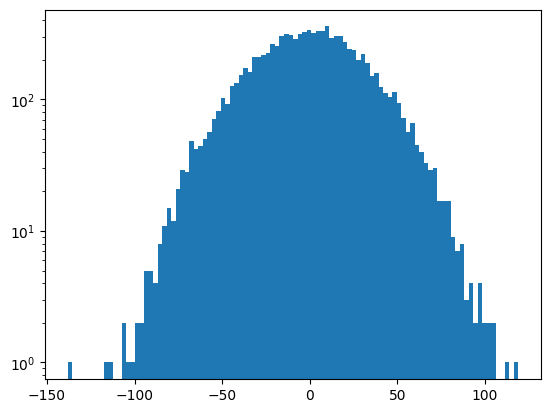

In [84]:
# histogram of attn_logits, y axis is log scale
plt.hist(attn_logits.flatten(), bins=100);
plt.yscale('log')

Ok, now let's apply the softmax and see what happens

In [81]:
attn_weights = jax.nn.softmax(attn_logits)

print_matrix("attn_weights", attn_weights)
print(f"[bold]attn_weights mean: {jnp.mean(attn_weights)}, std: {jnp.std(attn_weights)}[/bold]")

attn_weights
[[[5.7114778e-32 3.1836081e-35 5.2226629e-18 ... 4.4492078e-24
   1.2560164e-37 1.9816179e-19]
  [1.1625383e-33 5.9178798e-26 1.7099006e-34 ... 2.3632078e-13
   3.4202667e-26 1.2063388e-24]
  [0.0000000e+00 4.2237502e-32 5.4114768e-10 ... 2.1183873e-19
   0.0000000e+00 1.0136427e-23]
  ...
  [5.8082027e-31 0.0000000e+00 3.3209723e-24 ... 0.0000000e+00
   2.1331973e-26 6.8041377e-02]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.3019265e-33
   0.0000000e+00 0.0000000e+00]
  [9.8961004e-12 1.3124943e-29 1.1919438e-14 ... 3.5952226e-34
   7.4210611e-34 7.8158733e-18]]]

attn_weights mean: 0.009999999776482582, std: 0.09621075540781021

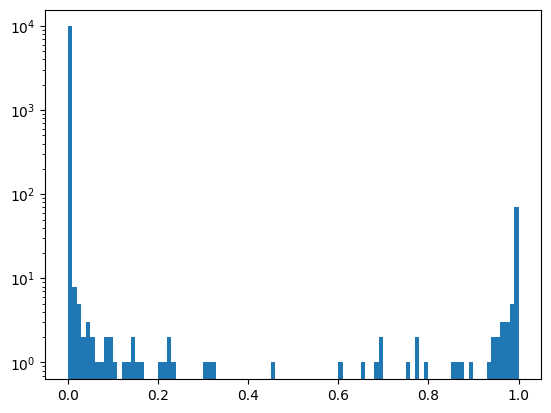

In [86]:
plt.hist(attn_weights.flatten(), bins=100);
plt.yscale('log')

We see two peaks, one at 0 and another at 1, which tells us that there are many places where the softmax is pushed to its extreme values. As we saw before that has an effect on the gradients, specifically leading to really small gradient values. 

### What's Going On and How Do We Fix That?

Time for some math! Check out this [post](https://ai.stackexchange.com/questions/21237/why-does-this-multiplication-of-q-and-k-have-a-variance-of-d-k-in-scaled) for some more info!

Our `Q` and `K` matrices have values that are sampled from a standard normal distribution. Let's call values of `Q` random variables `X` and values of `K` random variables `Y`, where `X` and `Y` are independent random variables. Since all values will be independent and identically distributed (iid) let's consider an arbitrary entry in both matrices $X_ii$ and $Y_jj$

$$ X_ii \sim \mathcal{N}(0, 1)$$
$$ Y_jj \sim \mathcal{N}(0, 1)$$

we also know that

$$\mathbb{E}[X_ii] = \mathbb{E}[Y_jj] = 1$$
$$Var[X_ii] = Var[Y_jj] = 1$$

We observed earlier that when we multiply our two matrices, the variance explodes. Therefore, it would be great if we could figure out an expression for the variance of our matrix product since that could give us insights into what's going on. How do we find an expression for the variance of an entry of our result matrix? 

Let's start by calling our result matrix `R`, it's defined as 

$$R = Q \cdot K^T$$

What does a single entry in `R` look like? What are the operations that result in that value? 
Assuming you are familar with linear algebra, a single value of `R`, say $R_{r,c}$ is defined as the vector dot product between row `r` of the `Q` matrix and column `c` of the $K^T$ matrix. It looks something like this

$$
\begin{bmatrix}
- & Q_r & - \\
\end{bmatrix}
\begin{bmatrix}
|\\
K^T_c \\
|\\
\end{bmatrix} = Q_{r1} * K^T_{c1} + Q_{r2} * K^T_{c2} + \ldots = \sum_{d=dim(Q_{r})=dim(K^T_{c})}Q_{rd} * K^T_{cd}
$$

Let's take a quick step back and remember that values from our `Q` and `K` matrices are random variables `X` and `Y`. This means that a single entry of our `R` (result) matrix will be a random variable as well. Let's call it `Z_l`. The expected value and variance of `Z_l` will be given by

$$\mathbb{E}[Z_l] = \mathbb{E}[\sum_{d}Q_{rd} * K^T_{cd}] = \mathbb{E}[\sum_{d}X_{rd} * Y_{cd}]$$
$$Var[Z_l] = Var[\sum_{d}Q_{rd} * K^T_{cd}] = Var[\sum_{d}X_{rd} * Y_{cd}]$$

Cool. So what on earth do we do with that? We recall that `X` and `Y` are independent and identically distributed. We also recall the following proporties for expectations and variances of IID variables.

$$\mathbb{E}[X + Y] = \mathbb{E}[X] + \mathbb{E}[Y]$$
$$Var[X + Y] = Var[X] + Var[Y]$$

This means we can rewrite our equations from before as

$$\mathbb{E}[Z_l] = \mathbb{E}[\sum_{d}X_{rd} * Y_{cd}] = \sum_{d}\mathbb{E}[X_{rd} * Y_{cd}]$$
$$Var[Z_l] = Var[\sum_{d}Q_{rd} * K^T_{cd}] = \sum_{d}Var[X_{rd} * Y_{cd}]$$

Ok, awesome! But what now?
Let's tackle our expected value first. We recall another property of expectations of IID random variables
$$\mathbb{E}[XY] = \mathbb{E}[X]\mathbb{E}[Y]$$

Which lets us re-write our expected value of `Z` as 
$$\mathbb{E}[Z_l] = \sum_{d}\mathbb{E}[X_{rd} * Y_{cd}] = \sum_{d}\mathbb{E}[X_{rd}] * \mathbb{E}[Y_{cd}] = \sum_{d}0 * 0 = 0$$

That's great, because it's in line with what we saw when we did our experiment earlier. However, what do we do with the variance? That one is a bit tougher. I did not recall the equation for the variance of the product of two random variables, so I re-derived it from the defintion of variance. The derivation will be added at the very end, since it takes up a bit of space. I would have personally wanted to see it so I'm sure others will too! 

$$Var[XY] = (Var[X] + \mathbb{E}[X]^2) * (Var[Y] + \mathbb{E}[Y]^2)$$

In our case, this means that 

$$Var[X_{rd} * Y_{cd}] = (Var[X_{rd}] + \mathbb{E}[X_{rd}]^2) * (Var[Y_{cd}] + \mathbb{E}[Y_{cd}]^2) = Var[X_{rd}] * Var[Y_{cd}]$$

Finally, we substitute this result into our earlier definition of $Var[Z_l]$ to get

$$Var[Z_l] = \sum_{d}Var[X_{rd} * Y_{cd}] = \sum_{d}Var[X_{rd}] * Var[Y_{cd}]$$

From earlier we know that $Var[X_{rd}] = Var[Y_{cd}] = 1$, so therefore

$$Var[Z_l] = \sum_{d}Var[X_{rd}] * Var[Y_{cd}] = \sum_{d} 1 = d$$

Putting all of that together, we get that our $Z_{ll}$ variable, which is a single entry of our result `R` matrix (product between `Q` and `K` matrices) is a random variable distributed according to 

$$Z_{ll} \sim \mathcal{N}(0, \sqrt{d})$$

What this means is, that when we multiply the queries and keys matrices, we get values that have a much larger range than the one we started out with. Our initial `Q` and `K` matrices had a variance of `1` while our result matrix has a variance of $d^2$. Does this line up with our experimental observations? 

Well, from before we saw that our logits matrix had mean and std of 

`attn_logits mean: -0.15942378342151642, std: 31.27756118774414`

Squaring the standard deviation we get `961`, while our `d` in this case is `1000`, so yes, our experimental observations are pretty close!

You might already see how we are going to fix it. We want the variance of our result matrix to be equal to `1`, in other words $Var[Z_{ll}] = 1$

What do we need to do for that? Let's see!

$$Var[Z_{ll}] = \sum_{d}Var[X_{rd}] * Var[Y_{cd}] = \sum_{d} 1 = d$$

Therefore 

$$\frac{1}{d} * Var[Z_{ll}] = \frac{1}{d} * \sum_{d}Var[X_{rd}] * Var[Y_{cd}] = \frac{1}{d} * \sum_{d} 1 = \frac{d}{d} = 1$$

However, we know that 
$$Var[cX] = \mathbb{E}[c^2X^2] - \mathbb{E}[cX]^2 = c^2 * \mathbb{E}[X^2] - c^2 * \mathbb{E}[X]^2 = c^2 * (\mathbb{E}[X^2] - \mathbb{E}[X]^2) = c^2 * Var[X]$$

Aaaand, therefore

$$\frac{1}{d} * Var[Z_l] = Var[\frac{1}{\sqrt{d}} Z_{ll}]$$

Finally, we see that by dividing the product of the `Q` and `K` matrices by the square root of `d`, we ensure that the entries in our result matrix have a variance of 1! 

Let's see this in code!

In [88]:
# using the same q and k matrices

attn_logits = jnp.matmul(q, k.transpose((0, 2, 1)))
scaled_attn_logits = attn_logits / jnp.sqrt(d_k)

print_matrix("attn_logits", scaled_attn_logits)

print(f"[bold]attn_logits mean: {jnp.mean(scaled_attn_logits)}, std: {jnp.std(scaled_attn_logits)}[/bold]")

attn_logits
[[[ 0.01842282 -0.21850204  1.0349914  ...  0.5930381  -0.3935416
    0.93153185]
  [ 0.20205155  0.7632127   0.14143857 ...  1.680768    0.7458752
    0.85854846]
  [-0.92032737  0.5997168   2.2094638  ...  1.5244786  -1.5591336
    1.2099128 ]
  ...
  [ 0.32879567 -1.2207664   0.82081705 ... -0.9736331   0.6611913
    2.4454103 ]
  [-0.21114273  0.18068922  0.3114094  ...  1.1875175   0.03924951
   -0.3428164 ]
  [ 1.0864136  -0.21531129  0.87385404 ... -0.54751664 -0.52459896
    0.64206636]]]

attn_logits mean: -0.005041422322392464, std: 0.9890833497047424

YESSS!! The mean is (close to) 0 and the variance (and std) are close to 1! 

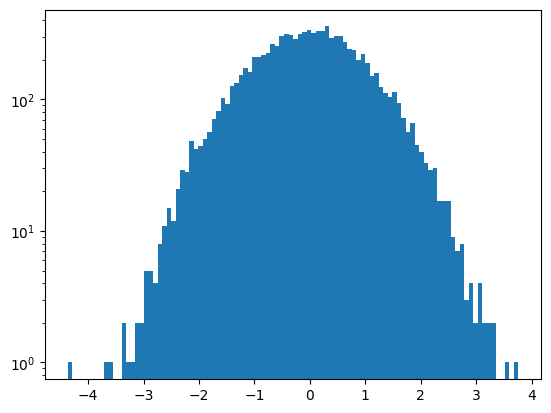

In [90]:
# histogram of attn_logits, y axis is log scale
plt.hist(scaled_attn_logits.flatten(), bins=100);
plt.yscale('log')

In [92]:
attn_weights = jax.nn.softmax(scaled_attn_logits)

print_matrix("attn_weights", attn_weights)
print(f"[bold]attn_weights mean: {jnp.mean(attn_weights)}, std: {jnp.std(attn_weights)}[/bold]")

attn_weights
[[[0.00673581 0.0053149  0.01861573 ... 0.01196581 0.00446145 0.01678604]
  [0.00707698 0.01240387 0.00666076 ... 0.0310489  0.01219067 0.0136446 ]
  [0.00214672 0.00981574 0.04909388 ... 0.02474811 0.0011333  0.01806874]
  ...
  [0.00887805 0.00188517 0.01452111 ... 0.00241368 0.01237871 0.0737143 ]
  [0.00365361 0.0054062  0.00616117 ... 0.01479628 0.00469317 0.00320285]
  [0.01864362 0.00507222 0.01507359 ... 0.00363851 0.00372286 0.01195509]]]

attn_weights mean: 0.009999998845160007, std: 0.011963767930865288

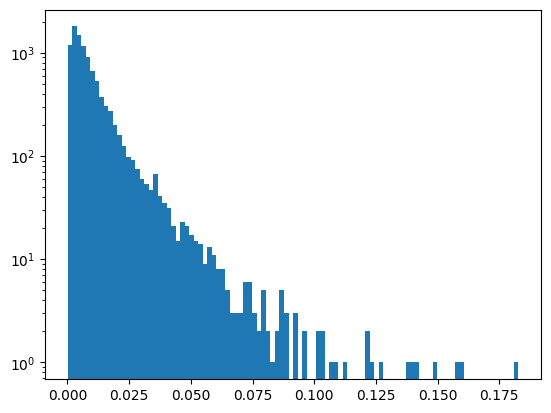

In [93]:
plt.hist(attn_weights.flatten(), bins=100);
plt.yscale('log')

## Deriving Variance Of A Product of `X` and `Y`

$$\begin{align*}
X &\sim \mathcal{N}(0,1) \\
Y &\sim \mathcal{N}(0,1) \\
X \text{ and } Y &\text{ are IID} \\
\text{Var}[XY] &= \mathbb{E}[X^2Y^2] - \mathbb{E}[XY]^2 \\
&= \mathbb{E}[X^2]\mathbb{E}[Y^2] - \mathbb{E}[X]^2\mathbb{E}[Y^2] \\
&= \mathbb{E}[X^2]\mathbb{E}[Y^2] - \mathbb{E}[Y^2]\mathbb{E}[X^2] + \mathbb{E}[Y^2]\mathbb{E}[X^2] \\
&= \mathbb{E}[X^2] \cdot \mathbb{E}[Y^2] - \mathbb{E}[Y^2] \cdot \mathbb{E}[X] ^ 2 + \mathbb{E}[Y^2] \cdot \mathbb{E}[X]^2 \\
&= \mathbb{E}[Y^2] \left( Var[X] + \mathbb{E}[X]^2 \right) = \mathbb{E}[Y^2] * B\\
&= \mathbb{E}[Y^2] * B = \mathbb{E}[Y^2] * B - \mathbb{E}[Y]^2 * B + \mathbb{E}[Y]^2 * B\\
&= B * \left( Var[Y] + \mathbb{E}[Y]^2 \right)\\
&= \left( Var[X] + \mathbb{E}[X]^2 \right) * \left( Var[Y] + \mathbb{E}[Y]^2 \right)\\
&= \left( Var[X] + 0 \right) * \left( Var[Y] + 0 \right)\\
&= Var[X]*Var[Y]\\
\end{align*}
$$
